# Maximization bias

In this excercise, we will see maximization bias in practice. We will have a chance to mitigate this effect.

## Goal:

- understanding effects from maximization bias
- how to mitigate this effect

In [ ]:
import gym
import chula_rl as rl
import os
import numpy as np
import random
from collections import deque, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: A toy env

This environment is hand-crafted to show the effect of maximization bias.

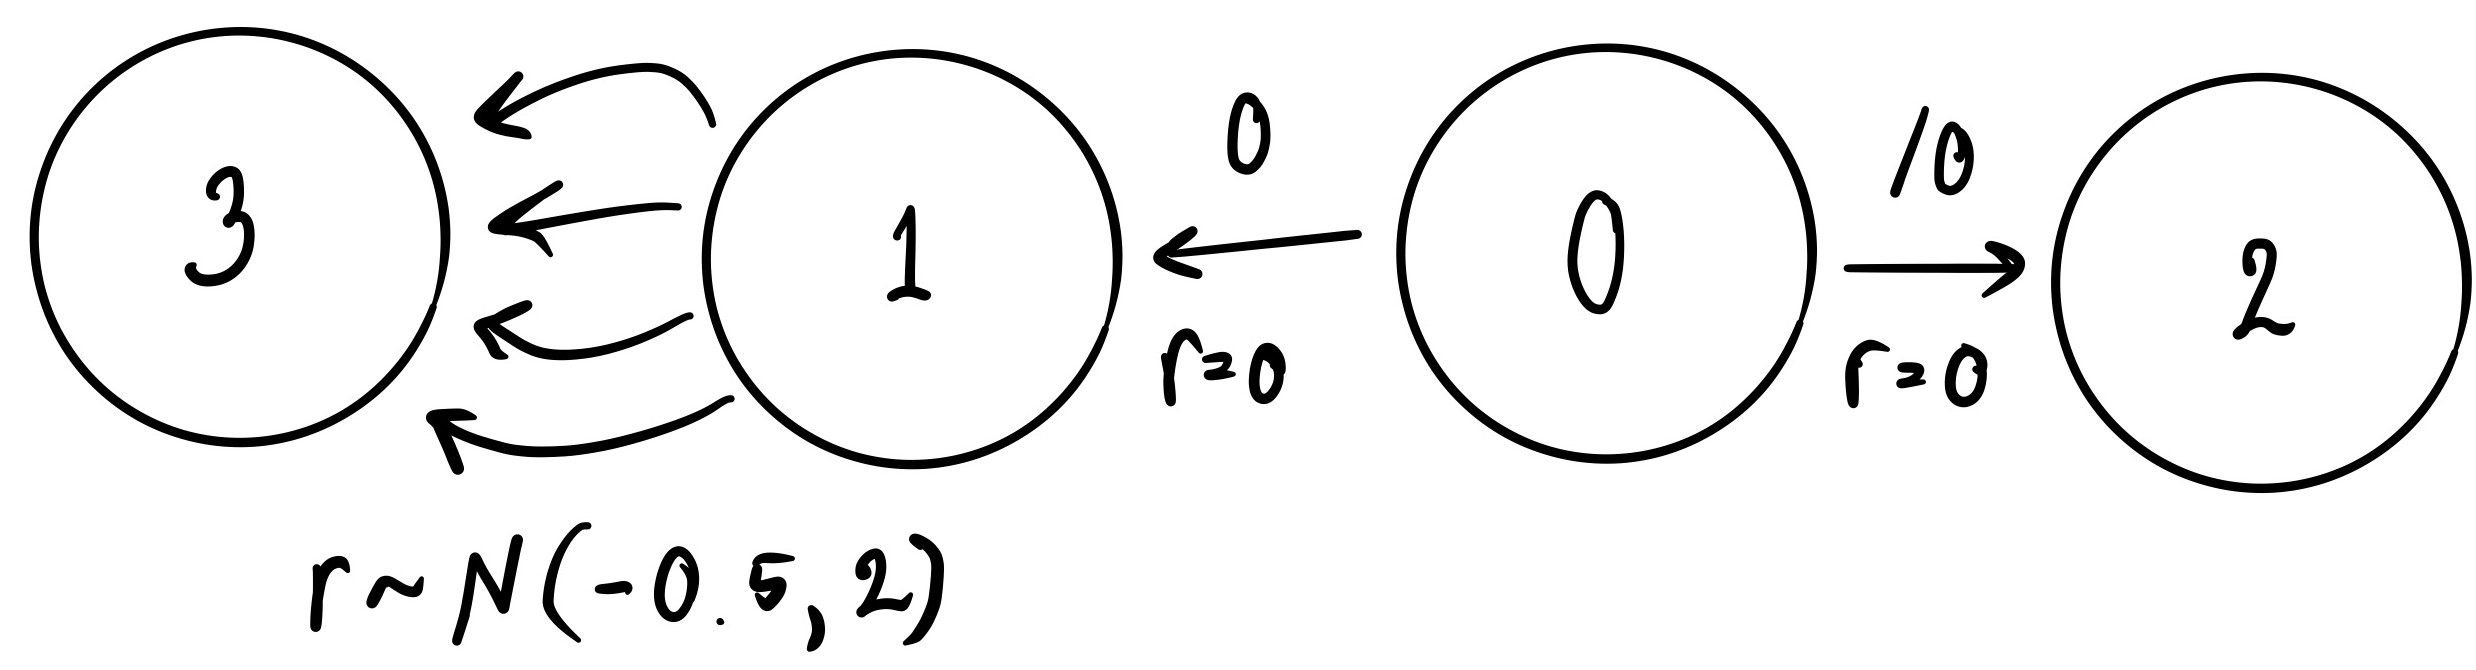

In [ ]:
class ToyEnv(gym.Env):
    """n_action, the larger the number the larger the effect"""
    def __init__(self, n_action, use_random=True):
        self.use_random = use_random
        self.s = None
        self.observation_space = gym.spaces.Discrete(4)
        self.action_space = gym.spaces.Discrete(n_action)
    
    def reset(self):
        self.s = 0
        return self.s
    
    def step(self, action):
        if self.s == 0:
            if action == 0:
                s = 1
                r = 0.0
                done = False
            else: 
                s = 2
                r = 0.0
                done = True
        elif self.s == 1:
            s = 3
            if self.use_random: 
                r = np.random.randn() * 2 - 0.5
            else:
                r = -0.5
            done = True
        self.s = s
        return s, r, done, {}

def make_env():
    env = ToyEnv(100, True)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env

def make_deterministic_env():
    env = ToyEnv(100, False)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env

env = make_env()

## Step 2: Define policy

### 2.1 Q-learning 

In [ ]:
class QlearningPolicy(rl.policy.BasePolicy):
    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        self.q = np.zeros([observation_space.n, n_action])

    def step(self, state):
        # code here ...
        # ...
        pass

    def optimize_step(self, data):
        s, a, r, ss, done = data['s'], data['a'], data['r'], data['ss'], data[
            'done']
        sa = (s, a)
        # code here ...
        # ...
        pass




### 2.2 SARSA

You could copy from previous works.

In [ ]:
class SARSAPolicy(rl.policy.BasePolicy):
    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        self.q = np.zeros([observation_space.n, n_action])

    def step(self, state):
        # code here ...
        # ...
        pass

    def optimize_step(self, data):
        # evaluation (prediction)
        s, a, r, ss, aa, done = data['s'], data['a'], data['r'], data[
            'ss'], data['aa'], data['done']
        sa = (s, a)
        ssaa = (ss, aa)
        # code here ...
        # ...
        pass

### 2.3 MC

You could copy from previous works. 

Note: this is first-visit constant learning rate Monte Carlo.

In [ ]:
def calculate_return(r, discount_factor):
    """return G for every time step given a sequence of rewards"""
    # code here ...
    # ...
    return g


def first_sa(s, a, g):
    """deduplicate (s, a) keeping only the first occurrances while also matching the corresponding returns"""
    # code here ...
    # ...
    
    # return unique sa and g
    # sa = tuple(first dim of s, second dim of s, a)
    # this is for numpy indexing!
    # ex: sa = ([0, 0], [0, 1], [1, 1])
    # means: s = [(0, 0), (0, 1)]; a = [1, 1]
    return sa, g


class MonteCarloPolicy(rl.policy.BasePolicy):
    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        self.q = np.zeros([observation_space.n, n_action])

    def step(self, state):
        # code here ...
        # ...
        pass

    def optimize_step(self, data):
        # evaluation (prediction)
        s = np.array(data['s'])
        a = np.array(data['a'])
        r = np.array(data['r'])
        
        # code here ...
        # ...
        pass


## Run experiments

We have implemented a `trainer` for you. Hopefully, this will do away the need of writing a traning loop.

You could look into the `trainer.py` if you wish.

In [ ]:
def run(make_env, policy_cls, explorer_cls, seed=0):
    rl.util.set_seed(seed)
    policy = policy_cls(0.1, 0.99, env.observation_space, env.action_space.n)
    policy = rl.policy.wrapper.EpsilonGreedy(policy, eps=0.1, n_action=env.action_space.n)
    # note: train function is a fancy training loop extendable and ready to use.
    df = rl.trainer.train(
        explorer_cls(1000, make_env()), 
        policy,
        make_env,
        callbacks=[
            # every 10 interactions, evaluate the policy performance for 100 interactions
            rl.trainer.EvalCb(10, 100),
        ]
    )
    return df

### Run SARSA

In [ ]:
# run the policy
df = run(make_env, SARSAPolicy, rl.explorer.OneStepExplorer, seed=0)

# see the result
ax = plt.subplot()
ax.set_title('SARSA')
df.plot('n_interaction', 'eval_return', ax=ax)
df.plot('n_interaction', 'eval_return_pred', ax=ax)
ax.legend(['return', 'pred'])

Expected result: 

You should see two-phases: 

1. It consistently over-estimates the q value
2. It converges to the correct q value

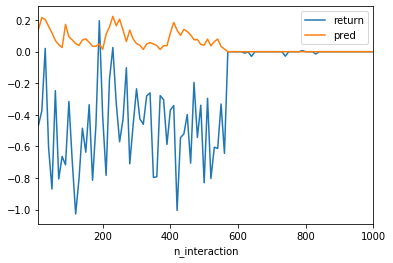

### Run Q-learning

In [ ]:
# run the policy
df = run(make_env, QlearningPolicy, rl.explorer.OneStepExplorer, seed=0)

# see the result
ax = plt.subplot()
ax.set_title('Q-learning')
df.plot('n_interaction', 'eval_return', ax=ax)
df.plot('n_interaction', 'eval_return_pred', ax=ax)
ax.legend(['return', 'pred'])

Expected result: very close to that of SARSA. Maximization bias is present.

### Run MC

In [ ]:
# run the policy
df = run(make_env, MonteCarloPolicy, rl.explorer.EpisodeExplorer, seed=0)

# see the result
ax = plt.subplot()
ax.set_title('Monte Carlo')
df.plot('n_interaction', 'eval_return', ax=ax)
df.plot('n_interaction', 'eval_return_pred', ax=ax)
ax.legend(['return', 'pred'])

Expeceted result: Monte Carlo should not have the maximization bias. It converges very fast.

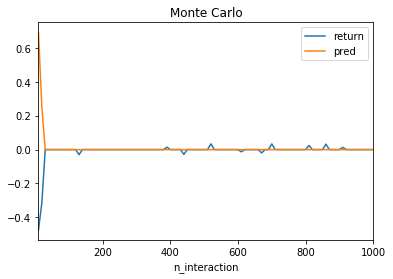

# Q1: What happens to the maximization bias if we increase/decrease the number of actions at the state 1? 

Describe here...

# Mitigating the maximization bias with double estimator

## Step 2: Define policy (Double Q Learning)

In [ ]:
class DoubleQlearningPolicy(rl.policy.BasePolicy):
    """Q-learning with double estimator"""
    
    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action
        self.q = np.zeros([observation_space.n, n_action])
        self.q2 = np.zeros([observation_space.n, n_action])

    def step(self, state):
        # code here ...
        # ...
        pass

    def optimize_step(self, data):
        s, a, r, ss, done = data['s'], data['a'], data['r'], data['ss'], data[
            'done']
        sa = (s, a)
        # code here ...
        # ...
        pass


### Run Q-learning vs Double Q-learning

The result varies so much across runs. We hence average the results across many runs (10 runs).

In [ ]:
single = [run(make_env, QlearningPolicy, rl.explorer.OneStepExplorer, seed=i) for i in range(10)]

In [ ]:
double = [run(make_env, DoubleQlearningPolicy, rl.explorer.OneStepExplorer, seed=i) for i in range(10)]

### Comparing prediction value (q-value)

We plot the mean + std to give a better idea about the result.

In [ ]:
ax = plt.subplot()
ax.set_title('prediction')
rl.util.plot_std(ax, pd.concat(single).groupby('n_interaction'), 'eval_return_pred')
rl.util.plot_std(ax, pd.concat(double).groupby('n_interaction'), 'eval_return_pred')
ax.legend(['wo double', 'double'])

Expected result: Double Q-learning has much less maximization bias.

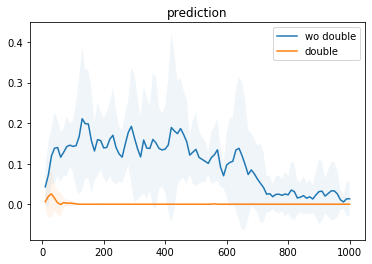

### Comparing total reward

In [ ]:
ax = plt.subplot()
ax.set_title('performance')
rl.util.plot_std(ax, pd.concat(single).groupby('n_interaction'), 'eval_reward')
rl.util.plot_std(ax, pd.concat(double).groupby('n_interaction'), 'eval_reward')
ax.legend(['wo double', 'double'])

Expected result: Of course, the double version learns better policy much faster.

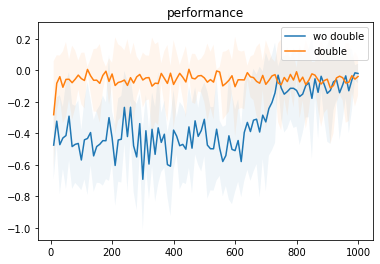